In [1]:
import matplotlib.pyplot as plt
import os 
import drjit as dr
import mitsuba as mi
import random
import numpy as np

mi.set_variant('cuda_ad_rgb')

In [2]:
from mitsuba import ScalarTransform4f as T

sensor_count = 1
sensor = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 256 * sensor_count, 'height': 256,
        'filter': {'type': 'gaussian'},
        'sample_border': True
    },
    'sensor_1' : {
        'type': 'perspective',
        'fov': 45,
        'to_world': T.look_at(target=[0, 0, 0], origin=[0, -7 , 2], up=[0, 0, 1])
    }
}

In [3]:
def create_sphere_light_source(position, radius, intensity):
    return {
        'type': 'sphere',
        'center': position,
        'radius': radius,
       'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': intensity,
            }
        }
    }

In [4]:
def create_spot_light_source(origin, target, up, intensity):
    return {'type': 'spot',
                    'to_world': mi.ScalarTransform4f.look_at(
                        origin=origin,
                        target=target,
                        up=up
                    ),
                    'intensity': {
                        'type': 'spectrum',
                        'value': intensity,
                    }
            }

In [5]:
from mitsuba import ScalarTransform4f as T

scene_dict_ref = {
    'type': 'scene',
    'integrator': {
        'type': 'prb_reparam',
        'reparam_rays' : 64,
    },
    'sensor': sensor,
    'sphere_0': create_sphere_light_source([-6.0, -9, 6.0], 0.2, 150.0),
    'sphere_1': create_sphere_light_source([6, -9, 6], 0.2, 150.0),
    'sphere_2': create_sphere_light_source([0, -9, -6.0], 0.2, 150.0),
    'spot_1': create_spot_light_source([3, -1.5, -0.8], [0,0,0], [0,0,1], 5.0),
    'spot_2': create_spot_light_source([-3, -1.5, -0.8], [0,0,0], [0,0,1], 5.0),
    'spot_3': create_spot_light_source([0, 0, 3], [0,0,0], [0,1,0], 30.0),

    'heightfield': {
        'type': 'heightfield',
        'filename': 'data/depth.bmp',
        'max_height': 1.0,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.0, 0.0]
            }
        },
        'to_world':T.translate((0,0,-0.5)) 
    },
    'floor_plane': {
        'type': 'rectangle',
        'material': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.8, 0.8, 0.8]
            }
        },
        'to_world':T.translate((0,2,0)) @ T.rotate([1,0,0], 90) @  T.scale((5, 5, 1))
    },
    'right_wall': {
        'type': 'rectangle',
        'material': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.8, 0.8, 0.8]
            }
        },
        'to_world':T.translate((3,0,0)) @ T.rotate([0,1,0], -90) @ T.rotate([1,0,0], 30) @ T.scale((3, 3, 1))
    },
    'left_wall': {
        'type': 'rectangle',
        'material': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.8, 0.8, 0.8]
            }
        },
        'to_world':T.translate((-3,0,0)) @ T.rotate([0,1,0], 90) @ T.rotate([1,0,0], 30) @ T.scale((3, 3, 1))
    }
}
scene_ref = mi.load_dict(scene_dict_ref)
scene_dict_ref['heightfield'] = {
                                    'type': 'heightfield',
                                    'resolution': 200,
                                    'max_height': 1.0,
                                    'bsdf': {
                                        'type': 'diffuse',
                                        'reflectance': {
                                            'type': 'rgb',
                                            'value': [0.5, 0.0, 0.0]
                                                }
                                            },
                                            'to_world':T.translate((0,0,-0.5)) 

                                }
scene_src = mi.load_dict(scene_dict_ref)

In [6]:
def plot_batch_output(out: mi.TensorXf):
    fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
    ax.imshow(mi.util.convert_to_bitmap(out))
    ax.axis('off')

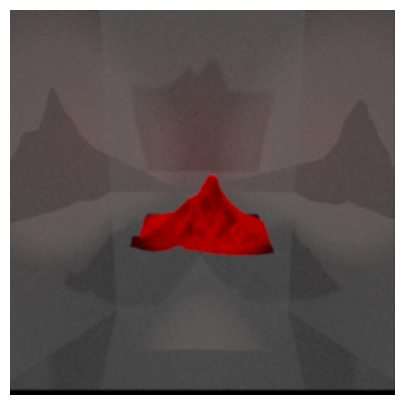

In [7]:
ref_img = mi.render(scene_ref, spp=256)
plot_batch_output(ref_img)

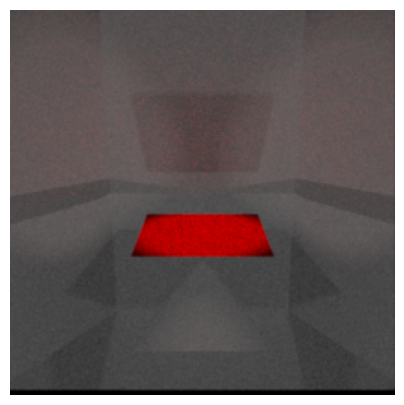

In [8]:
init_img = mi.render(scene_src, spp=128)
plot_batch_output(init_img)

In [9]:
params = mi.traverse(scene_src)
res_x = params['heightfield.res_x']
res_y = params['heightfield.res_y']

In [10]:
def init_optimizer(lambda_, learning_rate = 0.1):
    ls = mi.ad.LargeSteps(params['heightfield.heightfield'], lambda_)
    opt = mi.ad.Adam(lr=learning_rate, uniform=True)
    opt['u'] = ls.to_differential(dr.clamp(params['heightfield.heightfield'], 0.0, 1.0), True)
    return ls, opt

In [11]:
iterations = 300
upsampling_steps = [50, 100, 200]

In [12]:
lambda_ = 30
ls, opt = init_optimizer(lambda_, 0.7)

In [13]:
for it in range(iterations):
    loss = mi.Float(0.0)
    
    if it in upsampling_steps:
        lambda_ -= 3
        ls, opt = init_optimizer(lambda_, 0.7 * opt.lr['u'])

    # Retrieve the vertex positions frimageom the latent variable
    t = dr.unravel(mi.Point3f, ls.from_differential(opt['u']))
    params['heightfield.heightfield'] = mi.TensorXf(t.z, (res_x,res_y,1))
    params.update()

    img = mi.render(scene_src, params, seed=it, spp=512)
    mi.util.write_bitmap(f"output/shadows/iteration_{it}.png", img)
    
    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')

KeyboardInterrupt: 